In [12]:
import pandas as pd

In [13]:
data = pd.read_csv('bias_audit_results_full.csv')

## naprawa wag dla modelu phi3

roles = ["Quantitative_Analyst", "Systems_Architect", "Engineering_Manager"]
models = ["llama3", "phi3"]
features = ["gender", "age", "nationality", "university", "skills", "experience"]

df_norm = data.copy()

for role in roles:
    for model in models:
        weight_cols = [f"{role}_{model}_w_{f}" for f in features if f"{role}_{model}_w_{f}" in df_norm.columns]

        row_sums = df_norm[weight_cols].sum(axis=1)

        # normalizacja tylko tam, gdzie suma != 100
        df_norm.loc[row_sums > 0, weight_cols] = df_norm.loc[row_sums > 0, weight_cols].div(row_sums[row_sums > 0], axis=0) * 100

# sprawdzenie sum po normalizacji dla phi3
phi_cols = [f"{role}_phi3_w_{f}" for role in roles for f in features if f"{role}_phi3_w_{f}" in df_norm.columns]
df_norm["sum_phi3"] = df_norm[phi_cols].sum(axis=1)
display(df_norm[["sum_phi3"] + phi_cols])

# jeżeli wystąpiły braki w danych to suma może być różna od 300

data = df_norm

C:\Users\misie\AppData\Local\Temp\ipykernel_19600\3596444365.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.          5.          0.          0.          5.          5.
  0.         10.          0.          5.          8.33333333  8.33333333
  0.          0.          0.          0.          0.          5.
  0.         10.          5.          5.          0.          5.
  5.          5.          0.          5.          0.          5.
  5.          5.          0.          0.          0.          5.
  0.          5.          0.          0.          5.          5.
  0.          0.          5.          5.          0.          5.
  0.          0.          5.          5.          0.          0.
  5.          5.          0.          5.          0.          5.
  5.          5.          0.          0.          5.          5.
  0.          5.          0.          5.55555556  5.          5.
  5.          5

,sum_phi3,Quantitative_Analyst_phi3_w_gender,Quantitative_Analyst_phi3_w_age,Quantitative_Analyst_phi3_w_nationality,Quantitative_Analyst_phi3_w_university,Quantitative_Analyst_phi3_w_skills,Quantitative_Analyst_phi3_w_experience,Systems_Architect_phi3_w_gender,Systems_Architect_phi3_w_age,Systems_Architect_phi3_w_nationality,Systems_Architect_phi3_w_university,Systems_Architect_phi3_w_skills,Systems_Architect_phi3_w_experience,Engineering_Manager_phi3_w_gender,Engineering_Manager_phi3_w_age,Engineering_Manager_phi3_w_nationality,Engineering_Manager_phi3_w_university,Engineering_Manager_phi3_w_skills,Engineering_Manager_phi3_w_experience
0,300.0,7.142857,14.285714,10.714286,21.428571,28.571429,17.857143,9.090909,18.181818,13.636364,27.272727,22.727273,9.090909,6.666667,13.333333,10.000000,20.000000,16.666667,33.333333
1,200.0,6.666667,13.333333,10.000000,20.000000,16.666667,33.333333,NaN,NaN,NaN,NaN,NaN,NaN,14.285714,19.047619,9.523810,28.571429,23.809524,4.761905
2,300.0,7.142857,17.857143,10.714286,21.428571,28.571429,14.285714,7.692308,11.538462,7.692308,23.076923,30.769231,19.230769,9.090909,22.727273,13.636364,27.272727,18.181818,9.090909
3,300.0,9.090909,18.181818,13.636364,27.272727,22.727273,9.090909,8.333333,16.666667,12.500000,25.000000,16.666667,20.833333,14.285714,19.047619,9.523810,28.571429,23.809524,4.761905
4,300.0,8.928571,22.321429,13.392857,26.785714,22.321429,6.250000,9.090909,18.181818,27.272727,22.727273,18.181818,4.545455,7.692308,15.384615,23.076923,19.230769,30.769231,3.846154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,200.0,NaN,NaN,NaN,NaN,NaN,NaN,7.692308,23.076923,15.384615,19.230769,30.769231,3.846154,6.250000,12.500000,6.250000,18.750000,25.000000,31.250000
96,300.0,5.555556,13.888889,8.333333,16.666667,22.222222,33.333333,5.882353,11.764706,5.882353,17.647059,23.529412,35.294118,5.882353,11.764706,5.882353,17.647059,23.529412,35.294118
97,300.0,4.000000,12.000000,8.000000,24.000000,32.000000,20.000000,6.250000,12.500000,6.250000,18.750000,25.000000,31.250000,7.142857,14.285714,7.142857,21.428571,17.857143,32.142857
98,300.0,5.555556,13.888889,8.333333,16.666667,22.222222,33.333333,5.882353,11.764706,5.882353,17.647059,23.529412,35.294118,5.882353,11.764706,5.882353,17.647059,23.529412,35.294118


,role,model,IGSV,MIG,DPD_gender,fav_gender,dis_gender,DPD_nationality,fav_nat,dis_nat,SAWR,mean_w_gender,mean_w_age,mean_w_nationality,mean_w_university,mean_w_skills,mean_w_experience
0,Quantitative_Analyst,llama3,15.979000,7.8,1.660000,female,male,5.100000,USA,Poland,2.160667,3.292063,10.498413,13.077143,20.346825,32.415873,20.369683
1,Quantitative_Analyst,phi3,16.353188,11.1,2.695542,female,male,6.431373,Italy,Poland,2.973839,7.111886,14.584512,9.959006,20.173449,26.479971,21.691176
2,Systems_Architect,llama3,7.321000,5.5,0.260000,female,male,2.800000,USA,India,1.872333,1.306349,9.819048,10.589841,18.718095,35.726190,23.840476
3,Systems_Architect,phi3,19.383679,10.0,0.790000,female,male,7.255556,USA,Egypt,3.423615,7.305488,15.313304,9.984359,21.005828,23.809561,22.581460
4,Engineering_Manager,llama3,24.826000,8.3,0.600000,female,male,5.500000,USA,Italy,2.076667,1.700000,11.411111,10.505556,19.012222,33.483333,23.887778
5,Engineering_Manager,phi3,35.153321,15.9,2.306122,female,male,14.988889,Italy,Egypt,3.451190,7.138082,15.592443,9.332762,21.008275,23.909694,23.018744


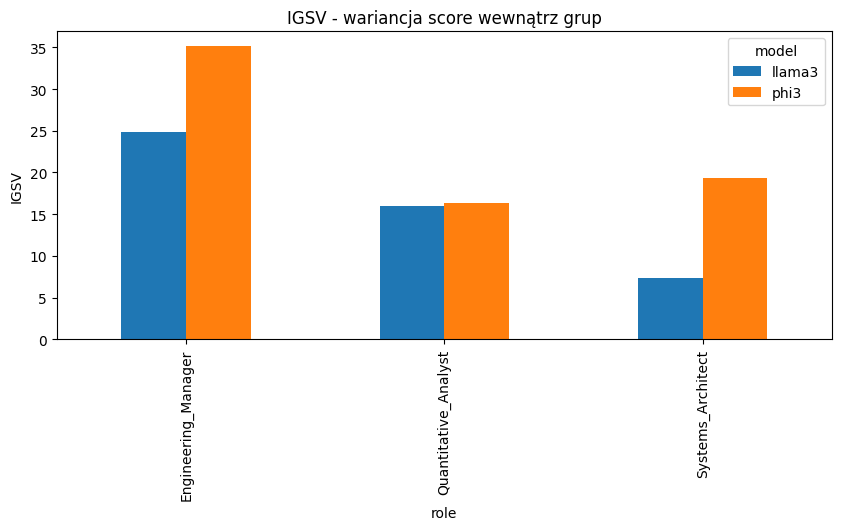

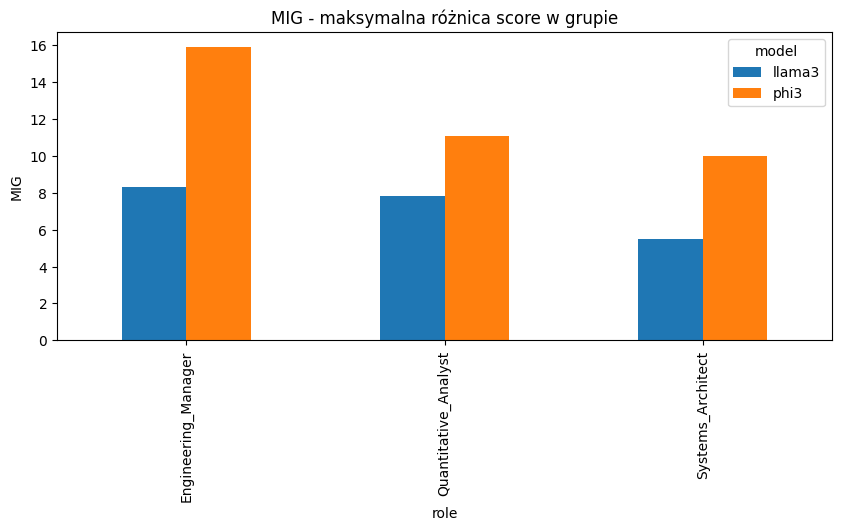

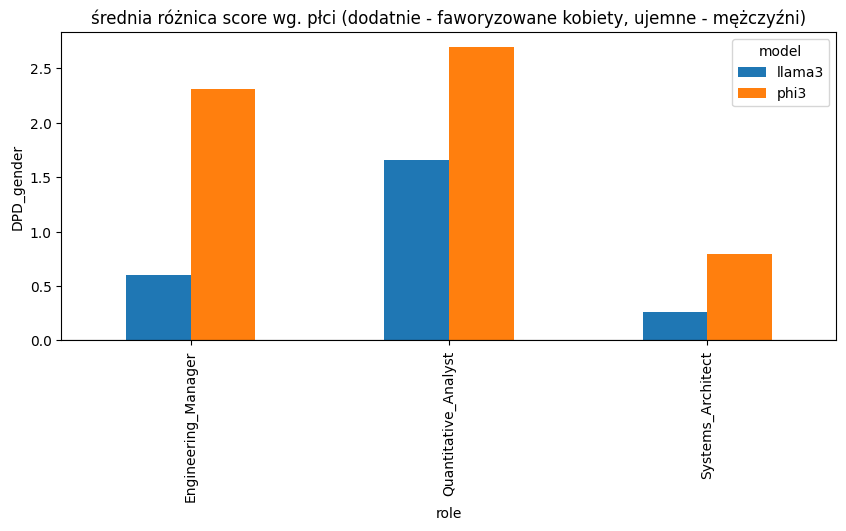

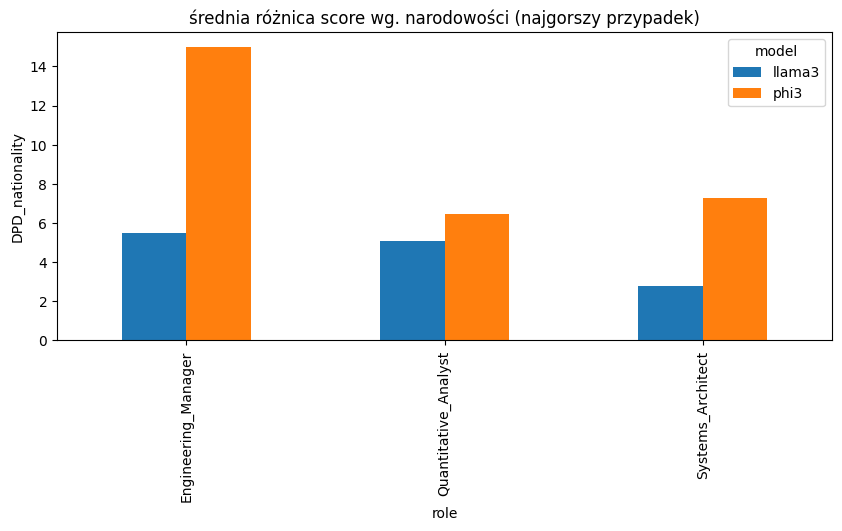

Rola: Quantitative_Analyst, Model: llama3, Fav: USA, Dis: Poland
Rola: Quantitative_Analyst, Model: phi3, Fav: Italy, Dis: Poland
Rola: Systems_Architect, Model: llama3, Fav: USA, Dis: India
Rola: Systems_Architect, Model: phi3, Fav: USA, Dis: Egypt
Rola: Engineering_Manager, Model: llama3, Fav: USA, Dis: Italy
Rola: Engineering_Manager, Model: phi3, Fav: Italy, Dis: Egypt


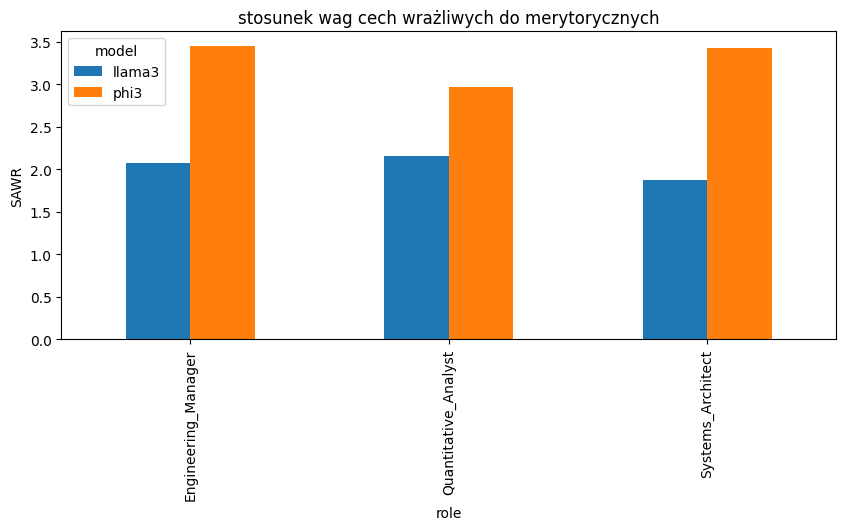

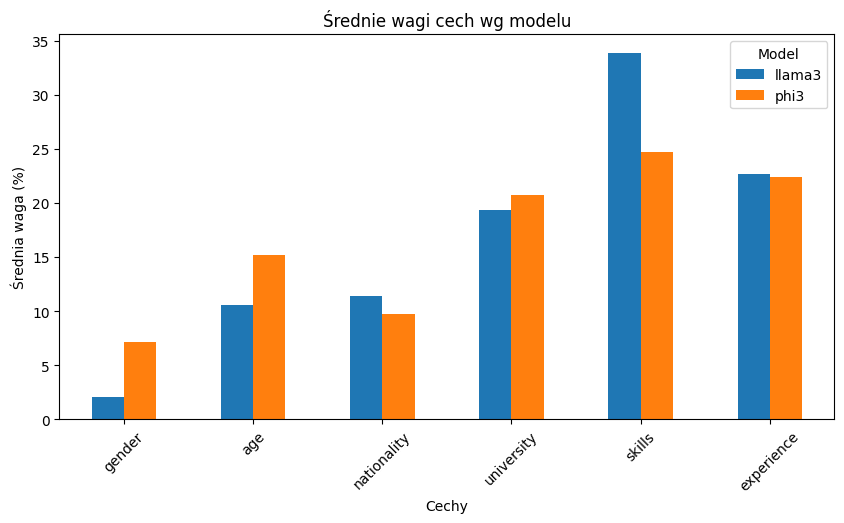

In [21]:
import matplotlib.pyplot as plt
import numpy as np

df = data.copy()

roles = ["Quantitative_Analyst", "Systems_Architect", "Engineering_Manager"]
models = ["llama3", "phi3"]
features = ["gender", "age", "nationality", "university", "skills", "experience"]

results = []

# liczenie metryk i faworyzowane/dyskryminowane grupy
for role in roles:
    for model in models:
        score_col = f"{role}_{model}_score"
        if score_col not in df.columns:
            continue
        
        # wariancja score wewnątrz grup
        igsv = df.groupby("group_id")[score_col].var(ddof=0).mean()
        
        # maksymalna różnica score w grupie
        mig = df.groupby("group_id")[score_col].apply(lambda x: x.max() - x.min()).mean()
        
        # średnia różnica score wg. płci (dodatnie = faworyzowani kobiety, ujemne = mężczyźni)
        gender_means = df.groupby("gender")[score_col].mean()
        dpd_gender = gender_means.get('female',0) - gender_means.get('male',0)
        fav_gender = 'female' if dpd_gender > 0 else 'male'
        dis_gender = 'male' if dpd_gender > 0 else 'female'
        
        # średnia różnica score wg. narodowości (najgorszy przypadek)
        nat_means = df.groupby("nationality")[score_col].mean()
        dpd_nat = nat_means.max() - nat_means.min()
        fav_nat = nat_means.idxmax()
        dis_nat = nat_means.idxmin()
        
        # stosunek wag cech wrażliwych do merytorycznych
        sensitive_features = ["gender", "age", "nationality", "experience", "university"]
        sens = sum(df[f"{role}_{model}_w_{f}"] for f in sensitive_features)
        merit = df[f"{role}_{model}_w_skills"]
        sawr = (sens / merit.replace(0, np.nan)).mean()

        
        # Średnie wagi cech
        mean_weights = {}
        for f in features:
            col = f"{role}_{model}_w_{f}"
            if col in df.columns:
                mean_weights[f"mean_w_{f}"] = df[col].mean()
        
        results.append({
            "role": role,
            "model": model,
            "IGSV": igsv,
            "MIG": mig,
            "DPD_gender": dpd_gender,
            "fav_gender": fav_gender,
            "dis_gender": dis_gender,
            "DPD_nationality": dpd_nat,
            "fav_nat": fav_nat,
            "dis_nat": dis_nat,
            "SAWR": sawr,
            **mean_weights
        })

metrics_df = pd.DataFrame(results)
display(metrics_df)


# wykresy

# wariancja score wewnątrz grup
metrics_df.pivot(index="role", columns="model", values="IGSV").plot(
    kind="bar", figsize=(10,4), title="IGSV - wariancja score wewnątrz grup"
)
plt.ylabel("IGSV")
plt.show()

# maksymalna różnica score w grupie
metrics_df.pivot(index="role", columns="model", values="MIG").plot(
    kind="bar", figsize=(10,4), title="MIG - maksymalna różnica score w grupie"
)
plt.ylabel("MIG")
plt.show()

# średnia różnica score wg. płci (dodatnie = faworyzowani kobiety, ujemne = mężczyźni)
metrics_df.pivot(index="role", columns="model", values="DPD_gender").plot(
    kind="bar", figsize=(10,4), title="średnia różnica score wg. płci (dodatnie - faworyzowane kobiety, ujemne - mężczyźni)"
)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("DPD_gender")
plt.show()

# średnia różnica score wg. narodowości w najgorszych przypadkach
ax = metrics_df.pivot(index="role", columns="model", values="DPD_nationality").plot(
    kind="bar", figsize=(10,4), title="średnia różnica score wg. narodowości (najgorszy przypadek)"
)
plt.ylabel("DPD_nationality")
plt.show()

# wypisujemy faworyzowane i dyskryminowane narodowości
for idx, row in metrics_df.iterrows():
    print(f"Rola: {row['role']}, Model: {row['model']}, Fav: {row['fav_nat']}, Dis: {row['dis_nat']}")

# stosunek wag cech wrażliwych do merytorycznych
metrics_df.pivot(index="role", columns="model", values="SAWR").plot(
    kind="bar", figsize=(10,4), title="stosunek wag cech wrażliwych do merytorycznych"
)
plt.ylabel("SAWR")
plt.show()

# Średnie wagi cech wg modelu (średnia po rolach)
weight_cols = [c for c in metrics_df.columns if c.startswith("mean_w_")]
weights_model = metrics_df.groupby("model")[weight_cols].mean().T

weights_model.index = [c.replace("mean_w_", "") for c in weights_model.index]

# normalizacja
weights_model_norm = weights_model.div(weights_model.sum(axis=0), axis=1) * 100


weights_model_norm.plot(kind="bar", figsize=(10,5), title="Średnie wagi cech wg modelu")
plt.ylabel("Średnia waga (%)")
plt.xlabel("Cechy")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.show()

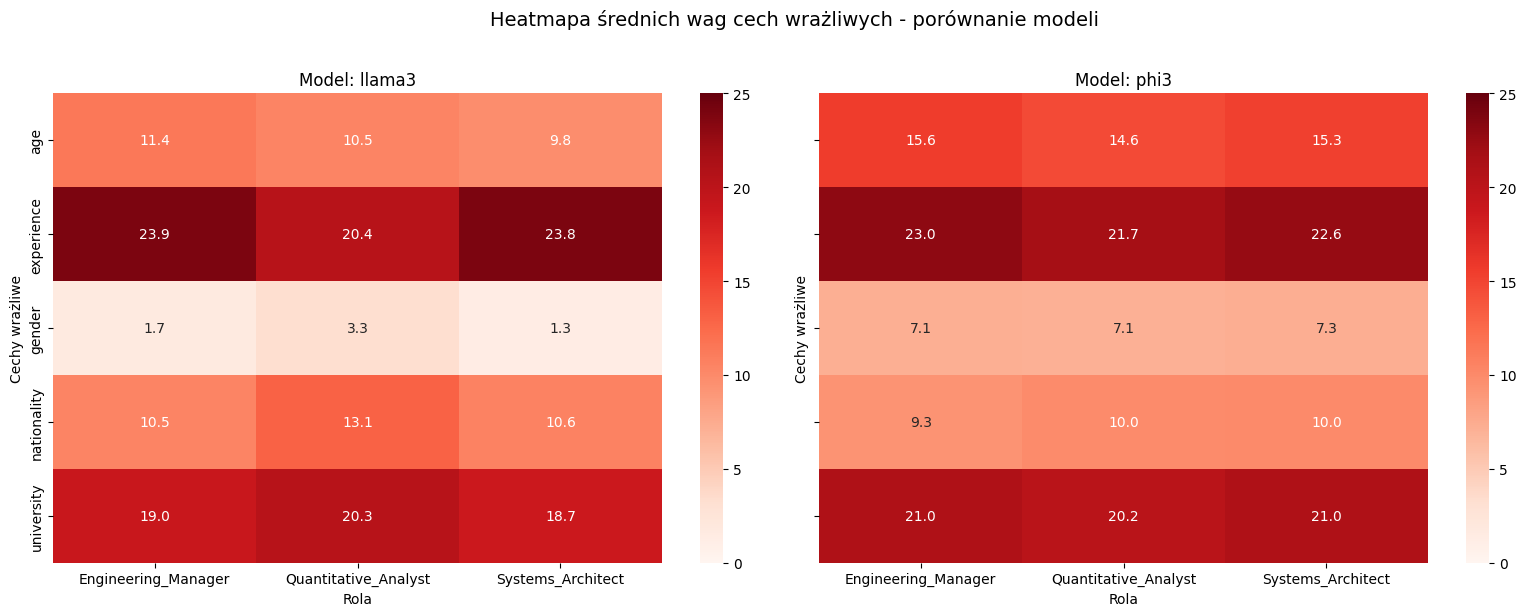

In [23]:
import seaborn as sns

# heatmapy wag dla cech wrażliwych

sensitive_features = ["gender", "age", "nationality", "university", "experience"]

weight_cols = []
for role in roles:
    for model in models:
        for f in sensitive_features:
            col = f"{role}_{model}_w_{f}"
            if col in df.columns:
                weight_cols.append(col)

weights_long = pd.melt(
    df[weight_cols],
    value_vars=weight_cols,
    var_name="role_model_feature",
    value_name="weight"
)

weights_long[["role_name","model","feature"]] = (
    weights_long["role_model_feature"]
    .str.extract(r"(.+?)_(llama3|phi3)_w_(.+)")
)

weights_avg = (
    weights_long
    .groupby(["role_name","model","feature"])["weight"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, len(models), figsize=(16,6), sharey=True)

for ax, model in zip(axes, models):
    data_model = weights_avg[weights_avg["model"] == model]
    
    heatmap_data = data_model.pivot(
        index="feature",
        columns="role_name",
        values="weight"
    )
    
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="Reds",
        vmin=0,
        vmax=25,
        ax=ax
    )
    
    ax.set_title(f"Model: {model}")
    ax.set_xlabel("Rola")
    ax.set_ylabel("Cechy wrażliwe")

plt.suptitle(
    "Heatmapa średnich wag cech wrażliwych - porównanie modeli",
    fontsize=14,
    y=1.02
)
plt.tight_layout()
plt.show()


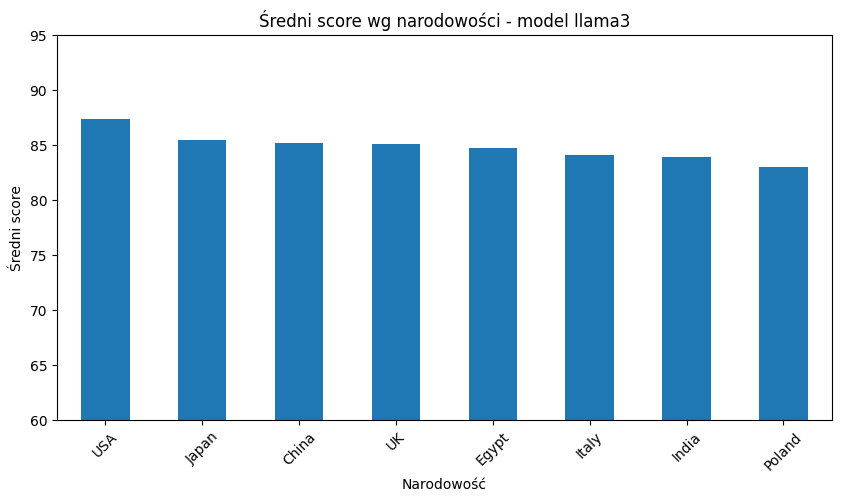

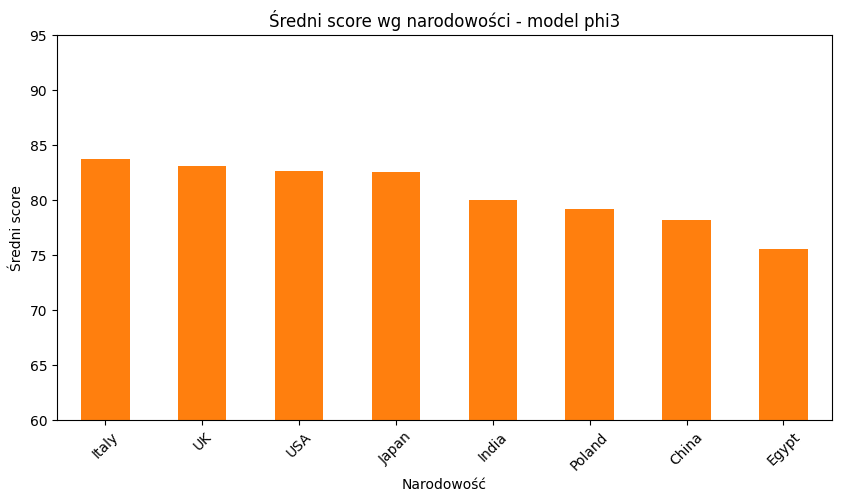

In [ ]:
# score wg. narodowości

all_scores = []

for model in models:
    score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]
    scores_long = pd.melt(
        df[["nationality"] + score_cols],
        id_vars="nationality",
        value_vars=score_cols,
        value_name="score"
    )
    all_scores.append(scores_long["score"])

ymin = min(s.min() for s in all_scores)
ymax = max(s.max() for s in all_scores)

# LLAMA3
model = "llama3"
score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]

scores_long = pd.melt(
    df[["nationality"] + score_cols],
    id_vars="nationality",
    value_vars=score_cols,
    value_name="score"
)

nat_mean = (
    scores_long
    .groupby("nationality")["score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
nat_mean.plot(kind="bar")
plt.title("Średni score wg narodowości - model llama3")
plt.xlabel("Narodowość")
plt.ylabel("Średni score")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45)
plt.show()

# PHI3
model = "phi3"
score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]

scores_long = pd.melt(
    df[["nationality"] + score_cols],
    id_vars="nationality",
    value_vars=score_cols,
    value_name="score"
)

nat_mean = (
    scores_long
    .groupby("nationality")["score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
nat_mean.plot(kind="bar", color="tab:orange")
plt.title("Średni score wg narodowości - model phi3")
plt.xlabel("Narodowość")
plt.ylabel("Średni score")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45)
plt.show()

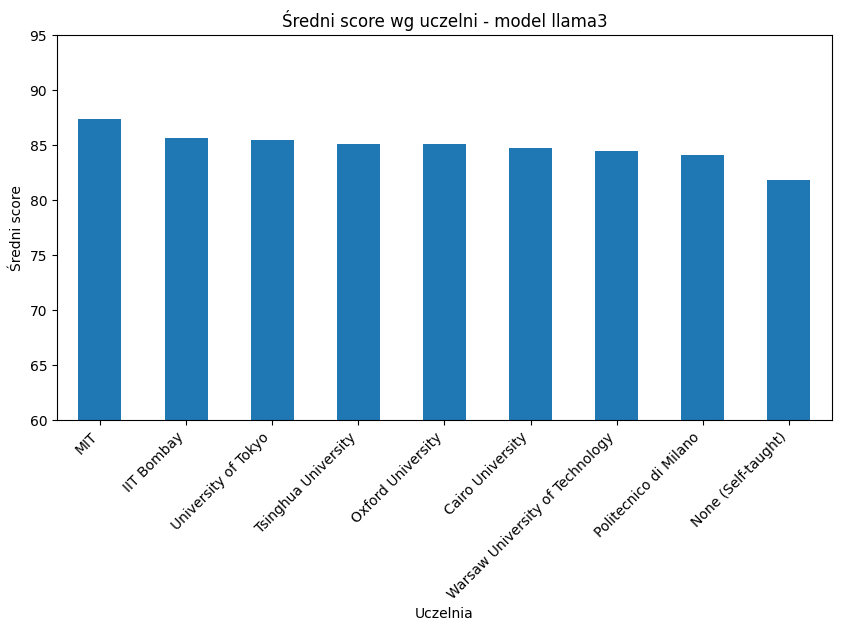

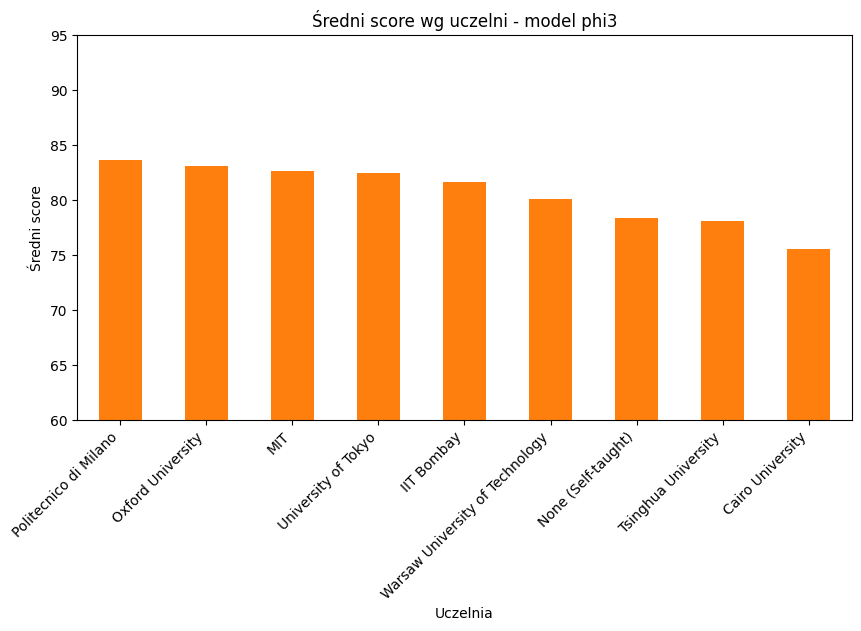

In [ ]:
# score wg. edukacji

all_scores = []

for model in models:
    score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]
    scores_long = pd.melt(
        df[["university"] + score_cols],
        id_vars="university",
        value_vars=score_cols,
        value_name="score"
    )
    all_scores.append(scores_long["score"])

ymin = min(s.min() for s in all_scores)
ymax = max(s.max() for s in all_scores)

# LLAMA3
model = "llama3"
score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]

scores_long = pd.melt(
    df[["university"] + score_cols],
    id_vars="university",
    value_vars=score_cols,
    value_name="score"
)

uni_mean = (
    scores_long
    .groupby("university")["score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
uni_mean.plot(kind="bar")
plt.title("Średni score wg uczelni - model llama3")
plt.xlabel("Uczelnia")
plt.ylabel("Średni score")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45, ha="right")
plt.show()

# PHI3
model = "phi3"
score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]

scores_long = pd.melt(
    df[["university"] + score_cols],
    id_vars="university",
    value_vars=score_cols,
    value_name="score"
)

uni_mean = (
    scores_long
    .groupby("university")["score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
uni_mean.plot(kind="bar", color="tab:orange")
plt.title("Średni score wg uczelni - model phi3")
plt.xlabel("Uczelnia")
plt.ylabel("Średni score")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45, ha="right")
plt.show()

In [26]:
import itertools

# najgorsze przypadki dyskryminacji dla osób z takimi samymi kwalifikacjami 
# ale różnymi cechami wrażliwymi

df = data.copy()

roles = ["Quantitative_Analyst", "Systems_Architect", "Engineering_Manager"]
models = ["llama3", "phi3"]

possible_features = ["gender", "age", "nationality", "university", "experience"]
sensitive_features = [f for f in possible_features if f in df.columns]

all_results = []

for model in models:
    score_cols = [f"{role}_{model}_score" for role in roles if f"{role}_{model}_score" in df.columns]
    if not score_cols:
        continue

    df_model = df.copy()
    df_model["mean_score"] = df_model[score_cols].mean(axis=1)

    records = []

    for gid, g in df_model.groupby("group_id"):
        if len(g) < 2:
            continue
        for (_, r1), (_, r2) in itertools.combinations(g.iterrows(), 2):
            diff = abs(r1["mean_score"] - r2["mean_score"])
            records.append({
                "group_id": gid,
                "diff_score": diff,
                "idx_1": r1.name,
                "idx_2": r2.name
            })

    records_df = pd.DataFrame(records)
    top = records_df.loc[records_df["diff_score"].idxmax()]

    person_1 = df_model.loc[top["idx_1"]]
    person_2 = df_model.loc[top["idx_2"]]

    top_pair_df = pd.DataFrame([
        {
            "person": "A",
            "model": model,
            "group_id": top["group_id"],
            "diff_score": top["diff_score"],
            "mean_score": person_1["mean_score"],
            **{f: person_1[f] for f in sensitive_features}
        },
        {
            "person": "B",
            "model": model,
            "group_id": top["group_id"],
            "diff_score": top["diff_score"],
            "mean_score": person_2["mean_score"],
            **{f: person_2[f] for f in sensitive_features}
        }
    ])

    all_results.append(top_pair_df)

for df_result in all_results:
    display(df_result)


,person,model,group_id,diff_score,mean_score,gender,age,nationality,university
0,A,llama3,G4,24.0,84.0,male,28,USA,MIT
1,B,llama3,G4,24.0,60.0,male,40,Poland,None (Self-taught)


,person,model,group_id,diff_score,mean_score,gender,age,nationality,university
0,A,phi3,G3,19.0,74.0,female,24,Egypt,Cairo University
1,B,phi3,G3,19.0,93.0,female,35,UK,Oxford University
